In [17]:
# importing necessary libraries
import pandas as pd
import numpy as np
import math

import random
from collections import Counter, defaultdict

import math
import time
import random
import os, sys
import json
from functools import partial
import pickle
import torchvision.transforms as transforms
from torchvision import datasets

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns


In [18]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True for M1/M2 GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.5.1+cu121
True
cuda


In [19]:
from torch.utils.data import DataLoader
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Vision Transformers (ViT)

We'd like to implement the transformer architecture taking inspiration from the paper
"AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE"
by Dosovitskiy et al. (2021)
The ViT architecture, from my understanding, is a lot like the original transformer from the paper "Attention Is All You Need" by Vaswani et al. (2017), in the sense that it(ViT) also contains the same encoder block that is present in the original transformer and additionally for the classification task we stick a MLP head on the "Classification token" on the transformer encoder output.

So, let's start by first constructing the transformer encoder Block.


## Transformer Encoder
The transformer encoder is made of of a few layers, formally:
* Batch Normalization
* Multi-headed Self Attention
* Residual Connect
* Batch Normalization
* Multi-layer Perceptron

The most complex and also the most crucial of them of them would be the Multi-headed self-Attention. So, let's start working on that first.
### In the comments, assume 'T' is the number of patches/sequence length

In [20]:
#Define the class for Self Attention Head
class SelfAttentionHead(nn.Module):
  #Define the init funtion
  def __init__(self, input_dim, embedding_dim) :
    super().__init__()
    self.weight_Q = nn.Linear(input_dim, embedding_dim)
    self.weight_K = nn.Linear(input_dim, embedding_dim)
    self.weight_V = nn.Linear(input_dim, embedding_dim)
    self.embedding_dim = embedding_dim

  #Define the forward pass for the self attention, Make sure the X is of size (N, T, P*P*C), where T is the number of image patches
  #P is the patch size and C is the number of channels, Hence P*P*C is actually the input dimention
  def forward(self, X):
    #compute the query, key and value matrices, each of them being (T x embedding_dim)
    Q = self.weight_Q(X)
    K = self.weight_K(X)
    V = self.weight_V(X)
    #Calculate the attention scores
    K_transpose = K.transpose(-2, -1)
    scale = torch.sqrt(torch.tensor(self.embedding_dim, dtype=torch.float32, device=X.device))
    attention_scores = Q @ K_transpose / scale
    self_attention_scores = nn.functional.softmax(attention_scores, dim = 2)
    #Calculate the output embeddings
    output_embeddings = self_attention_scores @ V

    return output_embeddings# The output should be of (N, T, embedding_dim)



In [21]:
#Now let's define the multi-head self attention encoder
class MultiHeadSelfAttention(nn.Module):
  #Define the init function with the initialization of the weights
  def __init__(self, input_dim, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.embedding_dim = input_dim//num_heads
    self.attention_heads = nn.ModuleList([SelfAttentionHead(input_dim, self.embedding_dim) for _ in range(num_heads)])
    self.linear = nn.Linear(self.num_heads * self.embedding_dim, input_dim)

  #Define the forward pass with the the above defined weights
  # X is of the dim (N, T, input_size)
  def forward(self, X):
    attention_outputs = [attention_head.forward(X) for attention_head in self.attention_heads] # Each entry is of size (N, T, embedding_dim)
    concatenated_output = torch.cat(attention_outputs, dim = -1) # concatenating along the rows, hence dimentions are (N, T, num_heads * embedding_dim)
    output_embeddings = self.linear(concatenated_output) # dim is (N, T, input_dim)
    return output_embeddings


In [22]:
#Alternate implementation of multi-head self attention head
#Unlike the original implementation, which used the self attention head, I'd try to calculate the attention scores for the attention head without explicetly calling the self attention head.
# I would try to ge the scores via matrix multiplicaiton itself.
class MultiHeadSelfAttention_2(nn.Module):
  def __init__(self, input_dim, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.embedding_dim = input_dim//num_heads
    self.weight_Q = nn.Linear(input_dim, self.num_heads * self.embedding_dim)
    self.weight_K = nn.Linear(input_dim, self.num_heads * self.embedding_dim)
    self.weight_V = nn.Linear(input_dim, self.num_heads * self.embedding_dim)

  #function to convert the Key, Query and Value matrices of dim (N, T, num_heads * embedding_dim) to dim dim (N, num_heads, T, embedding_dim)
  def change_dimentions(self, matrix) :
    new_shape = matrix.shape[:-1] + (self.num_heads, self.embedding_dim)
    return matrix.reshape(new_shape).permute(0, 2, 1, 3)

  #Define the forward function for the the input X which should be of the dimention (N, T, input_dim)
  def forward(self, X):
    # Define the Query, Key and Value vectors
    Q = self.weight_Q(X)
    K = self.weight_K(X)
    V = self.weight_V(X)

    # Change the dimentions of the Query, Key and Value vectors to account for the multi-head system
    Q = self.change_dimentions(Q)
    K = self.change_dimentions(K)
    V = self.change_dimentions(V)

    #Calculate the attention scores
    scale = torch.sqrt(torch.tensor(self.embedding_dim, dtype=torch.float32, device=X.device))
    attention_scores = Q @ K.transpose(-2, -1) / scale
    self_attention_scores = nn.functional.softmax(attention_scores, dim = -1)# Should be of the dim (N, num_heads, T, T)

    #Calculate the output embeddings
    output_embeddings = self_attention_scores @ V # Should be of the dim (N, num_heads, T, embedding_dim)

    #Reshape back to the original dimentions: dim (N, T, num_heads * embedding_dim)
    output_embeddings = output_embeddings.permute(0, 2, 1, 3)
    output_embeddings = output_embeddings.reshape(output_embeddings.shape[:-2] + (self.num_heads * self.embedding_dim,))

    return output_embeddings


In [23]:
#Now let's define a Multi-Layer Perceptron
class MLP(nn.Module):

  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.activation = nn.GELU()
    self.fc2 = nn.Linear(hidden_dim, output_dim)
#Define the forward pass with the the above defined weights
# X is of the dim (N, T, input_dim)
  def forward(self, X):
    output = self.fc1(X)
    output = self.activation(output)
    output = self.fc2(output)
    return output # Output would also be of dim (T x input_size)

In [24]:
#Now we're ready to define a the Transformer encoder
class TransformerEncoder(nn.Module):
  '''
  # Define the init function with the
  # input_dim being the dimention of the single input patch,
  # embedding_dim being the dimention of the encoder context word
  # num_heads being the number of the encoder blocks
  # hidden_dim being the dim of the hidden layer of the MLP
  # output_dim being the number of the classes
  '''
  def __init__(self, input_dim, num_heads, hidden_dim):
    super().__init__()
    self.multihead_self_attention = MultiHeadSelfAttention_2(input_dim, num_heads)
    self.layer_norm1 = nn.LayerNorm(input_dim)
    self.mlp = MLP(input_dim, hidden_dim, input_dim)
    self.layer_norm2 = nn.LayerNorm(input_dim)
    self.dropout1 = nn.Dropout(p=0.1)
    self.dropout2 = nn.Dropout(p=0.1)
      

  # Define the forward function
  # X would have the dim (N, T, input_dim)
  def forward(self, X):
    batchNormalization_1 = self.layer_norm1(X)# Do the batch normalization for the input. #TODO: Check if this would work
    #Calculate the Multi-head Attention Encoding for the patches
    multihead_self_attention_output = self.multihead_self_attention(batchNormalization_1)
    # Compute the residual Connection, will need to make sure that the dimentions of X and that of MSA match

    residual_connection_1 = X + self.dropout1(multihead_self_attention_output)

    batchNormalization_2 = self.layer_norm2(residual_connection_1)# Compute the batch normalization again

    #Calculate the MLP output from the Multi-layer perceptron
    mlp_output = self.mlp(batchNormalization_2)

    # Compute the residual Connection, will need to make sure that the dimentions of X and that of MLP match
    residual_connection_2 = residual_connection_1 + self.dropout2(mlp_output)
    return residual_connection_2


In [25]:
# Let's creat the entire ViT Transformer architecture with the the Encoder block, classigication Toen and the MLP head attached to the token
class ViT(nn.Module):
  def __init__(self,embedding_dim = 300, num_heads = 4, num_encoders = 1, hidden_dim = 100, classification_dim = 10, img_size = 32, patch_size = 16, overlapping = False):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.patch_size = patch_size
    self.input_dim = patch_size*patch_size*3
    self.linear_projection = nn.Linear(self.input_dim, embedding_dim)
    self.encoders = nn.ModuleList([TransformerEncoder(embedding_dim, num_heads, hidden_dim) for _ in range(num_encoders)])
    self.classification_token = nn.Parameter(torch.randn(1, embedding_dim))
    self.mlp_head = MLP(embedding_dim, hidden_dim, classification_dim)
    stride = patch_size
    if overlapping:
        stride = int(patch_size/2)
        self.project = nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=stride)
    else:
        self.project = nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=patch_size)
    sequence_length = ((img_size - patch_size)/stride) + 1
    self.embedding = nn.Embedding(int(sequence_length * sequence_length) + 1, embedding_dim) # +1 becuase of classiication token



# X is of dim (N, H, W, C)
  def forward(self, X):
    #Given the images of dim(N, W, H, C), project them to dim(N, T, embedding_dim)
    X = self.project(X.transpose(1,3)).flatten(2).transpose(1,2)

    #Add the classification token
    classification_token = self.classification_token.repeat(X.shape[0], 1, 1)
    X = torch.cat([classification_token, X], dim = 1)
    
    # Add the Projection embeddings
    projection_vectors = torch.tensor([[j for j in range(X.shape[1])] for i in range (X.shape[0])], device = X.device)
    # print(projection_vectors.shape)
    # print(self.embedding.weight.shape)
    projection_embeddings = self.embedding(projection_vectors)
    X = X + projection_embeddings


    # Calculate the encoder output,
    encoder_output = X
    for encoder in self.encoders:
      encoder_output = encoder(encoder_output)
        
    #the first column would be the classification token which would go to the MLP for the classification task
    mlp_head_output = self.mlp_head(encoder_output[:, 0, :])
    return mlp_head_output

## Working with the CIFAR-10 Dataset
I'll now load the data and create the training , validation as well as the test classes.

In [26]:
# Define transformations for training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip image horizontally with 50% chance
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomRotation(15),  # Rotate image by ±15 degrees
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),  # Normalize
])
# Define transformations for test set (no augmentation, just normalization)
test_transform = transforms.Compose([
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

    
def loadData():
  #Load the CIFAR 10 dataset from the torchvision
    train_dataset = datasets.CIFAR10(root="data", train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR10(root="data", train=False, transform=test_transform, download=True)
    x_train = np.array(train_dataset.data)
    y_train = np.array(train_dataset.targets)
    x_test = np.array(test_dataset.data)
    y_test = np.array(test_dataset.targets)
  #Normalize the data
    x_train = x_train/255
    x_test = x_test/255
    y_train = createLabels(y_train)
    y_test = createLabels(y_test)
    return (x_train, y_train), (x_test, y_test)

def createLabels(labels):
  new_labels = np.zeros((labels.size, labels.max() + 1))
  for i in range(labels.size):
    new_labels[i][labels[i]] = 1
  return new_labels

# maintain a train-val split
def splitDateTrainVal(x_data, y_data, train_split = 0.8):
  datalength = len(x_data)
  trainSplit = train_split
  valSplit = 1- train_split

  train_size = int(datalength * trainSplit)
  val_size = datalength - train_size

  #Shuffle the training dataset
  indices = np.random.permutation(datalength)
  x_data = x_data[indices]
  y_data = y_data[indices]

  #Split the dataset to training and validation
  x_train = x_data[:train_size]
  y_train = y_data[:train_size]
  x_val = x_data[train_size:]
  y_val = y_data[train_size:]

  return x_train, y_train, x_val, y_val

# Now, write a generator that yields (random) mini-batches of the input data
# Do not use same set of mini-batches for different epochs

def get_minibatch(training_x, training_y, batchSize = 32, index = 0):
    ## Read about Python generators if required.

    ## WRITE CODE HERE
    mini_x = []
    mini_y = []
    sequence = random.sample(range(training_x.shape[0]), training_x.shape[0])
    count = 1
    for i in range(training_x.shape[index]):
      mini_x.append(training_x[sequence[i], :])
      mini_y.append(training_y[sequence[i], :])
      if(len(mini_x) == batchSize):
        yield np.array(mini_x), np.array(mini_y)
        mini_x = []
        mini_y = []

    if mini_x:
      yield np.array(mini_x), np.array(mini_y)

## Training
Equipped with the Vision Transformer and the CIFAR-10 dataset, set's now train the model

In [27]:
USE_MPS = torch.cuda.is_available()

In [28]:
import torch

class EarlyStopping:
    def __init__(self, model, patience=5, min_delta=0.001):
        """
        Args:
            patience (int): Number of epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False
        self.model = model

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if loss improves
            self.model = model
        else:
            self.counter += 1  # Increase counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True


In [29]:
#Define the train function to train the above model
def train_ViT(x_training, y_training, x_val, y_val, model, optimizer, USE_MPS, max_iteration = 100, batch_size = 32):
  #Initialize
  criterion = nn.CrossEntropyLoss()
  training_loss = []
  validation_loss = []
  early_stopping = EarlyStopping(model,patience=3, min_delta=0.001)


  #Create the training and validation datasets
  for iter_num in range(max_iteration):
    model.train()

    #Create the batches for training
    minibatch = get_minibatch(x_training, y_training, batchSize = batch_size)
    train_loss = 0

    #Train the model on the minibatches
    batch_training_loss = []
    for mini_batch_x, mini_batch_y in minibatch:

      #Create the tensors for the mini batches
      mini_batch_x = torch.tensor(mini_batch_x, dtype=torch.float32)
      mini_batch_y = torch.tensor(mini_batch_y, dtype=torch.float32)
      if USE_MPS:
          mini_batch_x = mini_batch_x.to(device)
          mini_batch_y = mini_batch_y.to(device)
      optimizer.zero_grad()
      #Forward pass the model
      output = model(mini_batch_x)
      #Calculate the loss
      loss = criterion(output, mini_batch_y)
      #Backward pass the model
      loss.backward()
      optimizer.step()
      batch_training_loss.append(loss.item())

    average_train_loss = sum(batch_training_loss)/len(batch_training_loss)
    training_loss.append(average_train_loss)
    print(f"Epoch: {iter_num+1}/{max_iteration}, Training Loss: {average_train_loss}")

    #Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
      val_loss = 0
      batch_size = batch_size
      num_batches = math.ceil(len(x_val) / batch_size)  # Ensures last batch is included
      for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(x_val))  # Handle last batch

        val_x = torch.tensor(x_val[start_idx:end_idx]).to(dtype=torch.float32, device=device)
        val_y = torch.tensor(y_val[start_idx:end_idx]).to(dtype=torch.float32, device=device)
        #Generate the model outputs
        val_output = model(val_x)
        #Calculate the loss
        val_loss += criterion(val_output, val_y)
      val_loss /= num_batches
      validation_loss.append(val_loss.item())
    print(f"Epoch: {iter_num+1}/{max_iteration}, validation Loss: {val_loss}")
    # Check early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break  # Stop training

  #Plot the training and validation loss
  plt.plot(training_loss, label='Training Loss')
  plt.plot(validation_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  return early_stopping.model




## Training the Model

### Split the data into training, validation and test

In [30]:
(x_train, y_train), (x_test, y_test) = loadData()
x_training, y_training, x_val, y_val = splitDateTrainVal(x_train, y_train, 0.90)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
x_training.shape, y_training.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((45000, 32, 32, 3),
 (45000, 10),
 (5000, 32, 32, 3),
 (5000, 10),
 (10000, 32, 32, 3),
 (10000, 10))

In [32]:
#Don't delete demo data

demo_x_train = torch.randn(10, 32, 32, 3)
demo_y_train = torch.zeros(10, 10)
demo_x_val = torch.randn(10, 32, 32, 3)
demo_y_val = torch.zeros(10, 10)
for i in range(demo_y_train.shape[0]):
  index = random.randint(0, 9)
  demo_y_train[i][index] = 1
  demo_y_val[i][index] = 1

In [17]:
#Initialize Model and Optimizers
model = ViT(embedding_dim = 256, num_heads = 4, hidden_dim = 768, num_encoders= 6, classification_dim = 10, img_size = 32, patch_size=4)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-5)

Epoch: 1/5, Training Loss: 2.1276789903640747
Epoch: 1/5, validation Loss: 1.8265808820724487


<ipython-input-14-fa861dc3387d>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_x = torch.tensor(x_val[start_idx:end_idx]).to(dtype=torch.float32, device=device)
<ipython-input-14-fa861dc3387d>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_y = torch.tensor(y_val[start_idx:end_idx]).to(dtype=torch.float32, device=device)


Epoch: 2/5, Training Loss: 1.8032985925674438
Epoch: 2/5, validation Loss: 1.724853515625
Epoch: 3/5, Training Loss: 1.7102312445640564
Epoch: 3/5, validation Loss: 1.698331594467163
Epoch: 4/5, Training Loss: 1.6907179355621338
Epoch: 4/5, validation Loss: 1.676142692565918
Epoch: 5/5, Training Loss: 1.6132211685180664
Epoch: 5/5, validation Loss: 1.6421059370040894


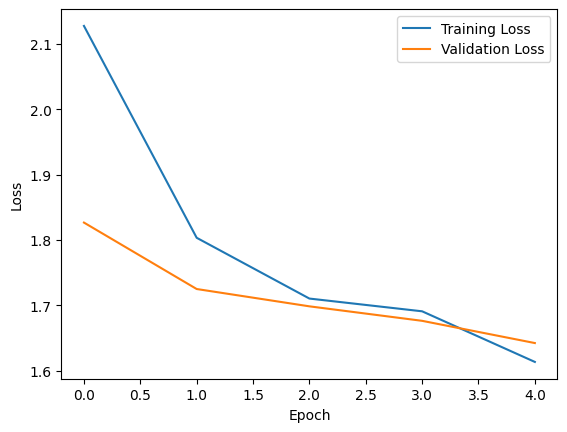

In [19]:
# trained_model = train_ViT(x_training, y_training,x_val, y_val, model, optimizer, USE_MPS, max_iteration = 30, batch_size = 128)
trained_model = train_ViT(demo_x_train, demo_y_train,demo_x_val, demo_y_val, model, optimizer, USE_MPS, max_iteration = 5, batch_size = 5)

In [20]:
#Test accuracy on the test set
# Test the trained models on the test dataset
model = trained_model
model.to(device)
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    batch_size = 128
    num_batches = math.ceil(len(x_test) / batch_size)  # Ensures last batch is included

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(x_test))  # Handle last batch

        test_x = torch.from_numpy(x_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)
        test_y = torch.from_numpy(y_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)

        test_output = model(test_x)
        predictions = torch.argmax(test_output, dim=1)
        correct_predictions = (predictions == torch.argmax(test_y, dim=1)).sum().item()

        total_correct += correct_predictions
        total_samples += test_y.shape[0]

accuracy = total_correct / total_samples
print(f"Test Accuracy for the model : {accuracy}")


KeyboardInterrupt: 

## Experiment 2
Train your model at different data sizes 5%, 10%, 25%, 50% and 100% of the training dataset

In [ ]:
training_percentages = [0.05, 0.1, 0.25, 0.5, 1]
model_list =[]
for percentage in training_percentages:
  #Initialize Model and Optimizers
  print(f"Training with {percentage * 100}% of the training data")
  model = ViT(embedding_dim = 256, num_heads = 4, hidden_dim = 768, num_encoders= 6, classification_dim = 10, img_size = 32, patch_size=4)
  model.to(device)
  # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
  optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-5)
  training_x, training_y, _, _ = splitDateTrainVal(x_training, y_training, percentage)
  trained_model = train_ViT(training_x, training_y, x_val, y_val, model, optimizer, USE_MPS, max_iteration = 30, batch_size = 256)
  model_list.append(trained_model)


In [ ]:
#Test the trained models on the test dataset
# Test the trained models on the test dataset
for model_idx, model in enumerate(model_list):
    model.to(device)
    model.eval()
    
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        batch_size = 128
        num_batches = math.ceil(len(x_test) / batch_size)  # Ensures last batch is included

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(x_test))  # Handle last batch

            test_x = torch.from_numpy(x_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)
            test_y = torch.from_numpy(y_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)

            test_output = model(test_x)
            predictions = torch.argmax(test_output, dim=1)
            correct_predictions = (predictions == torch.argmax(test_y, dim=1)).sum().item()

            total_correct += correct_predictions
            total_samples += test_y.shape[0]

    accuracy = total_correct / total_samples
    print(f"Test Accuracy for the model with {training_percentages[model_idx]}% of the training data : {accuracy}")


In [ ]:
percentages = [5, 10, 25, 50, 100]
for i in range(len(model_list)):
    model = model_list[i]
    model_name = "model" + str(percentages[i])
    torch.save(model.state_dict(), "/kaggle/working/" + model_name + ".pth")
    # print("/kaggle/working/" + model_name + ".pth")

## Experiment 3
Try different patch sizes with overlapping and non-overlapping patches

Let's first try for different patch sizes with 50% overlap

In [ ]:
patch_sizes = [4, 8, 16]
model_list = []
for patch_size in patch_sizes:
  #Initialize Model and Optimizers
  print(f"Training with patch size : {patch_size}")
  model = ViT(embedding_dim = 192, num_heads = 3, hidden_dim = 768, num_encoders = 6, classification_dim = 10, img_size = 32, patch_size = patch_size, overlapping = True)
  # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
  model.to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4, weight_decay = 0.05)
  trained_model = train_ViT(x_training, y_training, x_val, y_val, model, optimizer, USE_MPS, max_iteration = 15, batch_size = 256)
  model_list.append(trained_model)

In [ ]:
#Test the trained models on the test dataset
# Test the trained models on the test dataset
for model_idx, model in enumerate(model_list):
    model.to(device)
    model.eval()
    
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        batch_size = 128
        num_batches = math.ceil(len(x_test) / batch_size)  # Ensures last batch is included

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(x_test))  # Handle last batch

            test_x = torch.from_numpy(x_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)
            test_y = torch.from_numpy(y_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)

            test_output = model(test_x)
            predictions = torch.argmax(test_output, dim=1)
            correct_predictions = (predictions == torch.argmax(test_y, dim=1)).sum().item()

            total_correct += correct_predictions
            total_samples += test_y.shape[0]

    accuracy = total_correct / total_samples
    print(f"Test Accuracy for the model with {patch_sizes[model_idx]}  : {accuracy}")



In [ ]:
patch_sizes = [4, 8, 16]
for i in range(len(model_list)):
    model = model_list[i]
    model_name = "model_patch_overlapping_" + str(patch_sizes[i])
    torch.save(model.state_dict(), "/kaggle/working/" + model_name + ".pth")
    # print("/kaggle/working/" + model_name + ".pth")

Now, let's try with non-overlapping patches

In [ ]:
patch_sizes = [4, 8, 16]
model_list = []
for patch_size in patch_sizes:
  #Initialize Model and Optimizers
  print(f"Training with patch size: {patch_size}")
  model = ViT(embedding_dim = 256, num_heads = 4, hidden_dim = 768, num_encoders= 6, classification_dim = 10, img_size = 32, patch_size=4)
  model.to(device)
  # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
  optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-5)
  trained_model = train_ViT(x_training, y_training, x_val, y_val, model, optimizer,USE_MPS, max_iteration = 30, batch_size = 128)
  model_list.append(trained_model)

In [ ]:
#Test the trained models on the test dataset
# Test the trained models on the test dataset
for model_idx, model in enumerate(model_list):
    model.to(device)
    model.eval()
    
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        batch_size = 128
        num_batches = math.ceil(len(x_test) / batch_size)  # Ensures last batch is included

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(x_test))  # Handle last batch

            test_x = torch.from_numpy(x_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)
            test_y = torch.from_numpy(y_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)

            test_output = model(test_x)
            predictions = torch.argmax(test_output, dim=1)
            correct_predictions = (predictions == torch.argmax(test_y, dim=1)).sum().item()

            total_correct += correct_predictions
            total_samples += test_y.shape[0]

    accuracy = total_correct / total_samples
    print(f"Test Accuracy for the model with patch size : {patch_sizes[model_idx]}  : {accuracy}")

In [ ]:
patch_sizes = [4, 8, 16]
for i in range(len(model_list)):
    model = model_list[i]
    model_name = "model_patch_nonoverlapping_" + str(patch_sizes[i])
    torch.save(model.state_dict(), "/kaggle/working/" + model_name + ".pth")
    # print("/kaggle/working/" + model_name + ".pth")

## Experiment 4
Testing the model performance via attention heads

In [1]:
num_heads = [2, 4, 8]
model_list = []
for num_head in num_heads:
  #Initialize Model and Optimizers
  print(f"Training with {num_head} attention heads")
  model = ViT(embedding_dim = 64 * num_head, num_heads = num_head, hidden_dim = 768, num_encoders = 6, classification_dim = 10, img_size = 32, patch_size=4)
  model.to(device)
  # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9
  optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-5)
  trained_model = train_ViT(x_training, y_training, x_val, y_val, model, optimizer,USE_MPS, max_iteration = 30, batch_size = 128)
  model_list.append(trained_model)


Training with 2 attention heads


NameError: name 'ViT' is not defined

In [ ]:
# Test the trained models on the test dataset
for model_idx, model in enumerate(model_list):
    model.to(device)
    model.eval()
    
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        batch_size = 128
        num_batches = math.ceil(len(x_test) / batch_size)  # Ensures last batch is included

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(x_test))  # Handle last batch

            test_x = torch.from_numpy(x_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)
            test_y = torch.from_numpy(y_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)

            test_output = model(test_x)
            predictions = torch.argmax(test_output, dim=1)
            correct_predictions = (predictions == torch.argmax(test_y, dim=1)).sum().item()

            total_correct += correct_predictions
            total_samples += test_y.shape[0]

    accuracy = total_correct / total_samples
    print(f"Test Accuracy for the model with {num_heads[model_idx]} attention heads: {accuracy:.4f}")


In [ ]:

for i in range(len(model_list)):
    model = model_list[i]
    model_name = "model_patch_nonoverlapping_" + str(num_heads[i])
    torch.save(model.state_dict(), "/kaggle/working/" + model_name + ".pth")
    # print("/kaggle/working/" + model_name + ".pth")

## Experiment 5
Classification using the CLS token from different transformer encoder layer

In [17]:
# Let's creat the entire ViT Transformer architecture with the the Encoder block, classigication Toen and the MLP head attached to the token
# But this time, we'd pass the cls token through the MLP layer after every encoder block
class ViT_2(nn.Module):
  def __init__(self,embedding_dim = 300, num_heads = 4, num_encoders = 1, hidden_dim = 100, classification_dim = 10, img_size = 32, patch_size = 16, overlapping = False):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.patch_size = patch_size
    self.input_dim = patch_size*patch_size*3
    self.linear_projection = nn.Linear(self.input_dim, embedding_dim)
    self.encoders = nn.ModuleList([TransformerEncoder(embedding_dim, num_heads, hidden_dim) for _ in range(num_encoders)])
    self.classification_token = nn.Parameter(torch.randn(1, embedding_dim))
    self.mlp_head = MLP(embedding_dim, hidden_dim, classification_dim)
    stride = patch_size
    if overlapping:
        stride = int(patch_size/2)
        self.project = nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=stride)
    else:
        self.project = nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=patch_size)
    sequence_length = ((img_size - patch_size)/stride) + 1
    self.embedding = nn.Embedding(int(sequence_length * sequence_length) + 1, embedding_dim) # +1 becuase of classiication token



# X is of dim (N, H, W, C)
  def forward(self, X):
    #Given the images of dim(N, W, H, C), project them to dim(N, T, embedding_dim)
    X = self.project(X.transpose(1,3)).flatten(2).transpose(1,2)

    #Add the classification token
    classification_token = self.classification_token.repeat(X.shape[0], 1, 1)
    X = torch.cat([classification_token, X], dim = 1)
    
    # Add the Projection embeddings
    projection_vectors = torch.tensor([[j for j in range(X.shape[1])] for i in range (X.shape[0])], device = X.device)
    # print(projection_vectors.shape)
    # print(self.embedding.weight.shape)
    projection_embeddings = self.embedding(projection_vectors)
    X = X + projection_embeddings


    # Calculate the encoder output,
    encoder_output = X
    mlp_head_outputs = []
    for encoder in self.encoders:
      encoder_output = encoder(encoder_output)
      #the first column would be the classification token which would go to the MLP for the classification task
      mlp_head_output = self.mlp_head(encoder_output[:, 0, :])
      mlp_head_outputs.append(mlp_head_output)
        
    
    return mlp_head_output, mlp_head_outputs

In [40]:
#Define the train function to train the above model
def train_ViT_2(x_training, y_training, x_val, y_val, model, optimizer, USE_MPS, max_iteration = 100, batch_size = 32):
  #Initialize
  criterion = nn.CrossEntropyLoss()
  training_loss = []
  validation_loss = []
  early_stopping = EarlyStopping(model, patience=3, min_delta=0.001)


  #Create the training and validation datasets
  for iter_num in range(max_iteration):
    model.train()

    #Create the batches for training
    minibatch = get_minibatch(x_training, y_training, batchSize = batch_size)
    train_loss = 0

    #Train the model on the minibatches
    batch_training_loss = []
    for mini_batch_x, mini_batch_y in minibatch:

      #Create the tensors for the mini batches
      mini_batch_x = torch.tensor(mini_batch_x, dtype=torch.float32)
      mini_batch_y = torch.tensor(mini_batch_y, dtype=torch.float32)
      if USE_MPS:
          mini_batch_x = mini_batch_x.to(device)
          mini_batch_y = mini_batch_y.to(device)
      optimizer.zero_grad()
      #Forward pass the model
      output, _ = model(mini_batch_x)
      #Calculate the loss
      loss = criterion(output, mini_batch_y)
      #Backward pass the model
      loss.backward()
      optimizer.step()
      batch_training_loss.append(loss.item())

    average_train_loss = sum(batch_training_loss)/len(batch_training_loss)
    training_loss.append(average_train_loss)
    print(f"Epoch: {iter_num+1}/{max_iteration}, Training Loss: {average_train_loss}")

    #Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
      val_loss = 0
      #Create the tensors for the validation datasets
      
      val_x = torch.tensor(x_val, dtype=torch.float32, device = device)
      val_y = torch.tensor(y_val, dtype=torch.float32, device = device)
      #Generate the model outputs
      val_output, _ = model(val_x)
      #Calculate the loss
      val_loss = criterion(val_output, val_y)
      validation_loss.append(val_loss.item())

    print(f"Epoch: {iter_num+1}/{max_iteration}, validation Loss: {val_loss}")
    # Check early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break  # Stop training

  #Plot the training and validation loss
  plt.plot(training_loss, label='Training Loss')
  plt.plot(validation_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  return early_stopping.model

Epoch: 1/30, Training Loss: 1.9650525694543666
Epoch: 1/30, validation Loss: 1.745821475982666
Epoch: 2/30, Training Loss: 1.679103415798057
Epoch: 2/30, validation Loss: 1.625878095626831
Epoch: 3/30, Training Loss: 1.5371230779723688
Epoch: 3/30, validation Loss: 1.4615836143493652
Epoch: 4/30, Training Loss: 1.4407215470617467
Epoch: 4/30, validation Loss: 1.4024555683135986
Epoch: 5/30, Training Loss: 1.3687332770363851
Epoch: 5/30, validation Loss: 1.3678460121154785
Epoch: 6/30, Training Loss: 1.316117853264917
Epoch: 6/30, validation Loss: 1.3020683526992798
Epoch: 7/30, Training Loss: 1.2692928574979305
Epoch: 7/30, validation Loss: 1.274600625038147
Epoch: 8/30, Training Loss: 1.228087809275497
Epoch: 8/30, validation Loss: 1.2611479759216309
Epoch: 9/30, Training Loss: 1.179865725846453
Epoch: 9/30, validation Loss: 1.252530813217163
Epoch: 10/30, Training Loss: 1.1373451921072872
Epoch: 10/30, validation Loss: 1.2122098207473755
Epoch: 11/30, Training Loss: 1.104524628513238

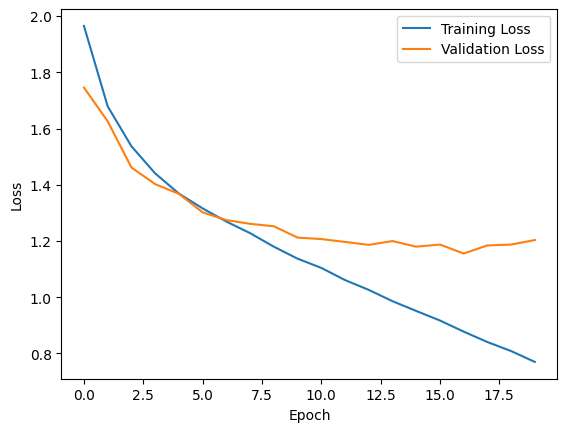

In [19]:
model = model = ViT_2(embedding_dim = 64 * 4, num_heads = 4, hidden_dim = 768, num_encoders = 6, classification_dim = 10, img_size = 32, patch_size=4)
model.to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-5)
trained_model = train_ViT_2(x_training, y_training, x_val, y_val, model, optimizer,USE_MPS, max_iteration = 30, batch_size = 128)


In [20]:
# Testing the models on the test data
#Test the trained models on the test dataset
#V2
model = trained_model
model.to(device)
model.eval()

# Dictionary to store accuracies for each layer
layer_accuracies = {}

# Disable gradient tracking
with torch.no_grad():
    batch_size = 128
    num_batches = math.ceil(len(x_test) / batch_size)  # Ensures last batch is included

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(x_test))  # Handle last batch
        
        test_x = torch.tensor(x_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)
        test_y = torch.tensor(y_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)

        output, test_outputs = model(test_x)  # Ensure model returns expected outputs

        for layer_number, test_output in enumerate(test_outputs, start=1):
            predictions = torch.argmax(test_output, dim=1)
            correct_predictions = (predictions == torch.argmax(test_y, dim=1)).sum().item()
            total_predictions = test_y.shape[0]
            accuracy = correct_predictions / total_predictions

            # Store accuracy per layer
            if layer_number not in layer_accuracies:
                layer_accuracies[layer_number] = []
            layer_accuracies[layer_number].append(accuracy)
# Compute and print the average accuracy per layer
for layer, accuracies in layer_accuracies.items():
    avg_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average accuracy for layer {layer}: {avg_accuracy:.4f}")


Average accuracy for layer 1: 0.1470
Average accuracy for layer 2: 0.2132
Average accuracy for layer 3: 0.2709
Average accuracy for layer 4: 0.3912
Average accuracy for layer 5: 0.4969
Average accuracy for layer 6: 0.5908


Let's now try a different method to check the cls token per layer accuracy. We'd train the model on layer going from 1 to 6. Then compare the test accuracy on the these model with varying number of encoder layers

Training with 1 Transformer encoder layers
Epoch: 1/30, Training Loss: 2.1339310583743183
Epoch: 1/30, validation Loss: 1.9808018207550049
Epoch: 2/30, Training Loss: 1.9193749045106498
Epoch: 2/30, validation Loss: 1.8336927890777588
Epoch: 3/30, Training Loss: 1.8286500471559437
Epoch: 3/30, validation Loss: 1.7575187683105469
Epoch: 4/30, Training Loss: 1.7542327683080325
Epoch: 4/30, validation Loss: 1.68935227394104
Epoch: 5/30, Training Loss: 1.7087482410398396
Epoch: 5/30, validation Loss: 1.650048851966858
Epoch: 6/30, Training Loss: 1.672083842144771
Epoch: 6/30, validation Loss: 1.620846152305603
Epoch: 7/30, Training Loss: 1.6475461602888324
Epoch: 7/30, validation Loss: 1.6149225234985352
Epoch: 8/30, Training Loss: 1.6243460662662983
Epoch: 8/30, validation Loss: 1.5766066312789917
Epoch: 9/30, Training Loss: 1.5994480326771736
Epoch: 9/30, validation Loss: 1.5571439266204834
Epoch: 10/30, Training Loss: 1.5791847732934086
Epoch: 10/30, validation Loss: 1.5390629768371582


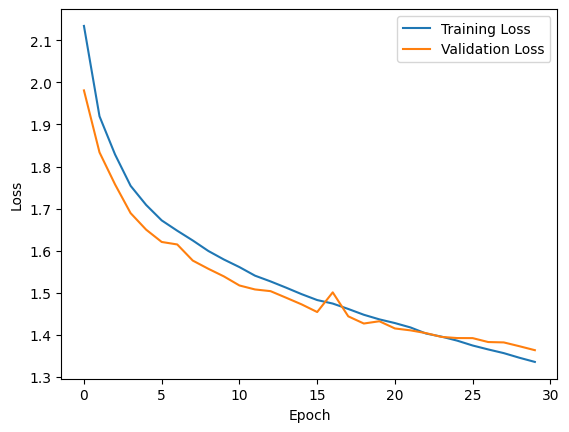

Training with 2 Transformer encoder layers
Epoch: 1/30, Training Loss: 2.026691211895509
Epoch: 1/30, validation Loss: 1.834299921989441
Epoch: 2/30, Training Loss: 1.7670508907599882
Epoch: 2/30, validation Loss: 1.666761040687561
Epoch: 3/30, Training Loss: 1.6491255960003897
Epoch: 3/30, validation Loss: 1.5912007093429565
Epoch: 4/30, Training Loss: 1.5879650420763276
Epoch: 4/30, validation Loss: 1.5445078611373901
Epoch: 5/30, Training Loss: 1.5470629805190996
Epoch: 5/30, validation Loss: 1.5117393732070923
Epoch: 6/30, Training Loss: 1.5126686211336742
Epoch: 6/30, validation Loss: 1.4810818433761597
Epoch: 7/30, Training Loss: 1.4785769188945943
Epoch: 7/30, validation Loss: 1.4897947311401367
Epoch: 8/30, Training Loss: 1.4484371129762044
Epoch: 8/30, validation Loss: 1.4203743934631348
Epoch: 9/30, Training Loss: 1.426852722736922
Epoch: 9/30, validation Loss: 1.4302486181259155
Epoch: 10/30, Training Loss: 1.407195540314371
Epoch: 10/30, validation Loss: 1.397875189781189
E

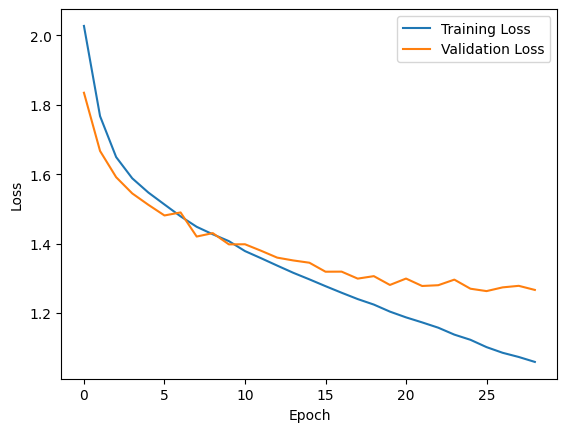

Training with 4 Transformer encoder layers
Epoch: 1/30, Training Loss: 1.9850017255680128
Epoch: 1/30, validation Loss: 1.809517502784729
Epoch: 2/30, Training Loss: 1.7108771631663495
Epoch: 2/30, validation Loss: 1.6159037351608276
Epoch: 3/30, Training Loss: 1.5789392126554793
Epoch: 3/30, validation Loss: 1.4874814748764038
Epoch: 4/30, Training Loss: 1.4871734522960403
Epoch: 4/30, validation Loss: 1.4156960248947144
Epoch: 5/30, Training Loss: 1.4250563159585
Epoch: 5/30, validation Loss: 1.4300487041473389
Epoch: 6/30, Training Loss: 1.3701637499034405
Epoch: 6/30, validation Loss: 1.3349239826202393
Epoch: 7/30, Training Loss: 1.329609234563329
Epoch: 7/30, validation Loss: 1.3052480220794678
Epoch: 8/30, Training Loss: 1.280414684929631
Epoch: 8/30, validation Loss: 1.2823188304901123
Epoch: 9/30, Training Loss: 1.251152384348891
Epoch: 9/30, validation Loss: 1.279090166091919
Epoch: 10/30, Training Loss: 1.2129169873554597
Epoch: 10/30, validation Loss: 1.2400423288345337
Epo

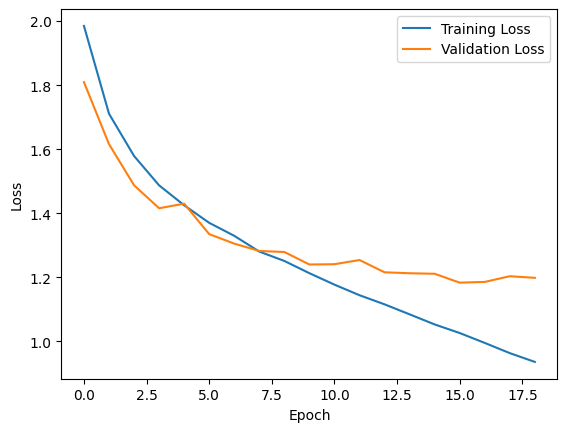

Training with 6 Transformer encoder layers
Epoch: 1/30, Training Loss: 1.9657325666736474
Epoch: 1/30, validation Loss: 1.7571830749511719
Epoch: 2/30, Training Loss: 1.6829321133819493
Epoch: 2/30, validation Loss: 1.587412714958191
Epoch: 3/30, Training Loss: 1.557654514570128
Epoch: 3/30, validation Loss: 1.4811577796936035
Epoch: 4/30, Training Loss: 1.4628505584868519
Epoch: 4/30, validation Loss: 1.407288908958435
Epoch: 5/30, Training Loss: 1.3881372342055494
Epoch: 5/30, validation Loss: 1.3745379447937012
Epoch: 6/30, Training Loss: 1.327219219031659
Epoch: 6/30, validation Loss: 1.3506526947021484
Epoch: 7/30, Training Loss: 1.2837187552993947
Epoch: 7/30, validation Loss: 1.299445390701294
Epoch: 8/30, Training Loss: 1.2335593260147355
Epoch: 8/30, validation Loss: 1.273061990737915
Epoch: 9/30, Training Loss: 1.1976649656214498
Epoch: 9/30, validation Loss: 1.2510014772415161
Epoch: 10/30, Training Loss: 1.1620657198469748
Epoch: 10/30, validation Loss: 1.2459129095077515
E

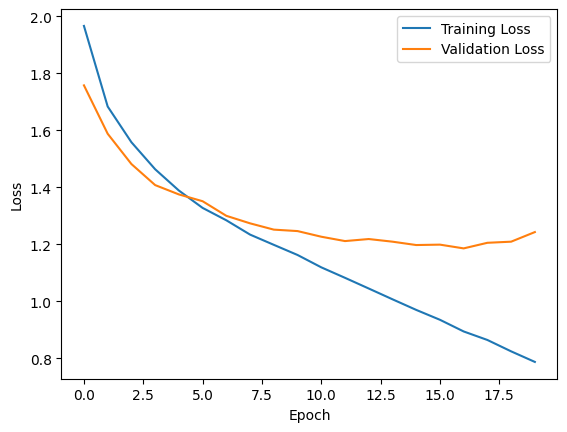

In [21]:
num_encoders = [1, 2, 4, 6]
model_list = []
for num_encoder in num_encoders:
  #Initialize Model and Optimizers
  print(f"Training with {num_encoder} Transformer encoder layers")
  model = ViT(embedding_dim = 256, num_heads = 4, hidden_dim = 768, num_encoders = num_encoder, classification_dim = 10, img_size = 32, patch_size=4)
  model.to(device)
  # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9
  optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-5)

  trained_model = train_ViT(x_training, y_training, x_val, y_val, model, optimizer,USE_MPS, max_iteration = 30, batch_size = 128)
  model_list.append(trained_model)


In [22]:
# Test the trained models on the test dataset
for model_idx, model in enumerate(model_list):
    model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        batch_size = 128
        num_batches = math.ceil(len(x_test) / batch_size)  # Ensures last batch is included

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(x_test))  # Handle last batch

            test_x = torch.tensor(x_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)
            test_y = torch.tensor(y_test[start_idx:end_idx]).to(dtype=torch.float32, device=device)

            test_output = model(test_x)
            predictions = torch.argmax(test_output, dim=1)
            correct_predictions = (predictions == torch.argmax(test_y, dim=1)).sum().item()

            total_correct += correct_predictions
            total_samples += test_y.shape[0]

    accuracy = total_correct / total_samples
    print(f"Test Accuracy for the model with {num_encoders[model_idx]} attention heads: {accuracy:.4f}")


Test Accuracy for the model with 1 attention heads: 0.5110
Test Accuracy for the model with 2 attention heads: 0.5514
Test Accuracy for the model with 4 attention heads: 0.5720
Test Accuracy for the model with 6 attention heads: 0.5859


In [23]:
for i in range(len(model_list)):
    model = model_list[i]
    model_name = "model_num_encoder_" + str(num_encoders[i])
    torch.save(model.state_dict(), "/kaggle/working/" + model_name + ".pth")
    # print("/kaggle/working/" + model_name + ".pth")

## Experiment 6
Visualize the attention maps for 2 images from every class

In [33]:
#Alternate implementation of multi-head self attention head
#Unlike the original implementation, which used the self attention head, I'd try to calculate the attention scores for the attention head without explicetly calling the self attention head.
# I would try to ge the scores via matrix multiplicaiton itself.
# Additionally, I'd also return the attention scores over here
class MultiHeadSelfAttention_3(nn.Module):
  def __init__(self, input_dim, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.embedding_dim = input_dim//num_heads
    self.weight_Q = nn.Linear(input_dim, self.num_heads * self.embedding_dim)
    self.weight_K = nn.Linear(input_dim, self.num_heads * self.embedding_dim)
    self.weight_V = nn.Linear(input_dim, self.num_heads * self.embedding_dim)

  #function to convert the Key, Query and Value matrices of dim (N, T, num_heads * embedding_dim) to dim dim (N, num_heads, T, embedding_dim)
  def change_dimentions(self, matrix) :
    new_shape = matrix.shape[:-1] + (self.num_heads, self.embedding_dim)
    return matrix.reshape(new_shape).permute(0, 2, 1, 3)

  #Define the forward function for the the input X which should be of the dimention (N, T, input_dim)
  def forward(self, X):
    # Define the Query, Key and Value vectors
    Q = self.weight_Q(X)
    K = self.weight_K(X)
    V = self.weight_V(X)

    # Change the dimentions of the Query, Key and Value vectors to account for the multi-head system
    Q = self.change_dimentions(Q)
    K = self.change_dimentions(K)
    V = self.change_dimentions(V)

    #Calculate the attention scores
    scale = torch.sqrt(torch.tensor(self.embedding_dim, dtype=torch.float32, device=X.device))
    attention_scores = Q @ K.transpose(-2, -1) / scale
    self_attention_scores = nn.functional.softmax(attention_scores, dim = -1)# Should be of the dim (N, num_heads, T, T)

    #Calculate the output embeddings
    output_embeddings = self_attention_scores @ V # Should be of the dim (N, num_heads, T, embedding_dim)

    #Reshape back to the original dimentions: dim (N, T, num_heads * embedding_dim)
    output_embeddings = output_embeddings.permute(0, 2, 1, 3)
    output_embeddings = output_embeddings.reshape(output_embeddings.shape[:-2] + (self.num_heads * self.embedding_dim,))

    return output_embeddings, self_attention_scores


In [34]:
#Now we're ready to define a the Transformer encoder
# We return both the Encoder output as well as the self attention scores.
class TransformerEncoder_2(nn.Module):
  '''
  # Define the init function with the
  # input_dim being the dimention of the single input patch,
  # embedding_dim being the dimention of the encoder context word
  # num_heads being the number of the encoder blocks
  # hidden_dim being the dim of the hidden layer of the MLP
  # output_dim being the number of the classes
  '''
  def __init__(self, input_dim, num_heads, hidden_dim):
    super().__init__()
    self.multihead_self_attention = MultiHeadSelfAttention_3(input_dim, num_heads) # use the version 3 of MSA to get the attention scores
    self.layer_norm1 = nn.LayerNorm(input_dim)
    self.mlp = MLP(input_dim, hidden_dim, input_dim)
    self.layer_norm2 = nn.LayerNorm(input_dim)


  # Define the forward function
  # X would have the dim (N, T, input_dim)
  def forward(self, X):
    layer_normalization_1 = self.layer_norm1(X)
    #Calculate the Multi-head Attention Encoding for the patches
    multihead_self_attention_output, self_attention_scores = self.multihead_self_attention(layer_normalization_1)
    # Compute the residual Connection, will need to make sure that the dimentions of X and that of MSA match

    residual_connection_1 = X + multihead_self_attention_output

    layer_normalization_2 = self.layer_norm2(residual_connection_1)

    #Calculate the MLP output from the Multi-layer perceptron
    mlp_output = self.mlp(layer_normalization_2)

    # Compute the residual Connection, will need to make sure that the dimentions of X and that of MLP match
    residual_connection_2 = residual_connection_1 + mlp_output
    return residual_connection_2, self_attention_scores #dim((N, num_heads, T, T))


In [35]:
# Let's creat the entire ViT Transformer architecture with the the Encoder block, classigication Toen and the MLP head attached to the token
class ViT_3(nn.Module):
  def __init__(self,embedding_dim = 300, num_heads = 4, num_encoders = 1, hidden_dim = 100, classification_dim = 10, img_size = 32, patch_size = 16, overlapping = False):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.patch_size = patch_size
    self.input_dim = patch_size*patch_size*3
    self.linear_projection = nn.Linear(self.input_dim, embedding_dim)
    self.encoders = nn.ModuleList([TransformerEncoder_2(embedding_dim, num_heads, hidden_dim) for _ in range(num_encoders)])
    self.classification_token = nn.Parameter(torch.randn(1, embedding_dim))
    self.mlp_head = MLP(embedding_dim, hidden_dim, classification_dim)
    stride = patch_size
    if overlapping:
        stride = int(patch_size/2)
        self.project = nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=stride)
    else:
        self.project = nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=patch_size)
    sequence_length = ((img_size - patch_size)/stride) + 1
    self.embedding = nn.Embedding(int(sequence_length * sequence_length) + 1, embedding_dim) # +1 becuase of classiication token

# X is of dim (N, H, W, C)
  def forward(self, X):
    #Given the images of dim(N, W, H, C), project them to dim(N, T, embedding_dim)
    X = self.project(X.transpose(1,3)).flatten(2).transpose(1,2)

    #Add the classification token
    classification_token = self.classification_token.repeat(X.shape[0], 1, 1)
    X = torch.cat([classification_token, X], dim = 1)

    # Add the Projection embeddings
    projection_vectors = torch.tensor([[j for j in range(X.shape[1])] for i in range (X.shape[0])], device = device)
    projection_embeddings = self.embedding(projection_vectors)
    X = X + projection_embeddings


    # Calculate the encoder output,
    encoder_output = X
    self_attention_scores = [] # We'd like to return the self attention scores from every transformer encoder layer. 
    for encoder in self.encoders:
      encoder_output, self_attention_score = encoder(encoder_output)
      self_attention_scores.append(self_attention_score)

    #the first column would be the classification token which would go to the MLP for the classification task
    mlp_head_output = self.mlp_head(encoder_output[:, 0, :])
    return mlp_head_output, self_attention_scores # dim(num_layers, N, T, T)

In [36]:
#First let's shuffle the test images
indices = np.random.permutation(x_test.shape[0])
x_test_shuffled = x_test[indices]
y_test_shuffled = y_test[indices]

In [37]:
# Take two image per class from the dataset
image_per_class = {}
for cls in range(y_test_shuffled.shape[1]):
  image_per_class[cls] = []
  for i in range(y_test_shuffled.shape[0]):
    if y_test_shuffled[i][cls] == 1:
      image_per_class[cls].append(x_test_shuffled[i])
      if len(image_per_class[cls]) == 2:
        break

In [38]:
classes = {0: "Airplane",
1:"Automobile",
2: "Bird",
3: "Cat",
4: "Deer",
5: "Dog",
6: "Frog",
7: "Horse",
8: "Ship",
9: "Truck"}

Epoch: 1/30, Training Loss: 1.9584310786290602
Epoch: 1/30, validation Loss: 1.8227620124816895
Epoch: 2/30, Training Loss: 1.6784446828744628
Epoch: 2/30, validation Loss: 1.615800142288208
Epoch: 3/30, Training Loss: 1.5575574660165743
Epoch: 3/30, validation Loss: 1.5321005582809448
Epoch: 4/30, Training Loss: 1.470890328626741
Epoch: 4/30, validation Loss: 1.4381963014602661
Epoch: 5/30, Training Loss: 1.4036881310695952
Epoch: 5/30, validation Loss: 1.4284611940383911
Epoch: 6/30, Training Loss: 1.3408461565321141
Epoch: 6/30, validation Loss: 1.3447318077087402
Epoch: 7/30, Training Loss: 1.2871084914288737
Epoch: 7/30, validation Loss: 1.3278741836547852
Epoch: 8/30, Training Loss: 1.246046378869902
Epoch: 8/30, validation Loss: 1.2896708250045776
Epoch: 9/30, Training Loss: 1.1990421194244514
Epoch: 9/30, validation Loss: 1.3138737678527832
Epoch: 10/30, Training Loss: 1.159261571582068
Epoch: 10/30, validation Loss: 1.2698888778686523
Epoch: 11/30, Training Loss: 1.11739284748

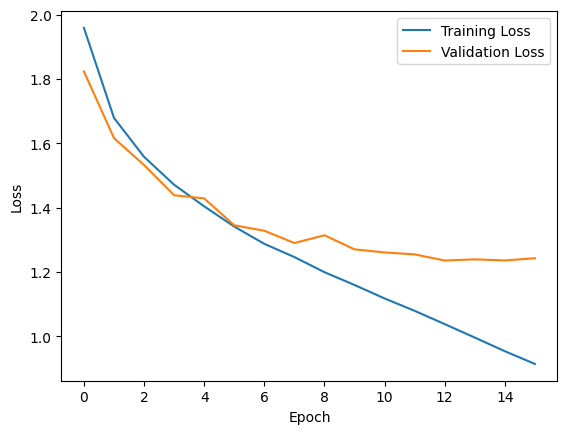

In [41]:
#Let's now train the mode with the best parameters that we've discovered till now
model = ViT_3(embedding_dim = 256, num_heads = 4, hidden_dim = 768, num_encoders = 4, classification_dim = 10, img_size = 32, patch_size=4)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-5)

trained_model = train_ViT_2(x_training, y_training, x_val, y_val, model, optimizer,USE_MPS, max_iteration = 30, batch_size = 128)
# trained_model = train_ViT_2(demo_x_train, demo_y_train, demo_x_val, demo_y_val, model, optimizer,USE_MPS, max_iteration = 15, batch_size = 5)

#### Attention Maps

In [42]:
# plot the attention maps per layer of an image along with image on the left
# Function to visualize attention for each layer
def plot_attention_layers(image, attn_maps, cls, index):
    os.makedirs("final_plots", exist_ok=True)
    num_layers = attn_maps.shape[0]
    fig, axes = plt.subplots(1, num_layers + 1, figsize=(num_layers * 4, 4))
    
    for i in range(num_layers + 1):
        if i == 0:
            axes[i].imshow(image)
            axes[i].set_title(classes.get(cls))
        else:
            sns.heatmap(attn_maps[i-1][0], cmap="viridis", ax=axes[i])
            axes[i].set_title(f"Layer {i}")
            axes[i].set_xticks([])
            axes[i].set_yticks([])
    
    plt.suptitle("Attention Maps Across Layers for "+ classes.get(cls)+ " " + str(index))
    plt.show()


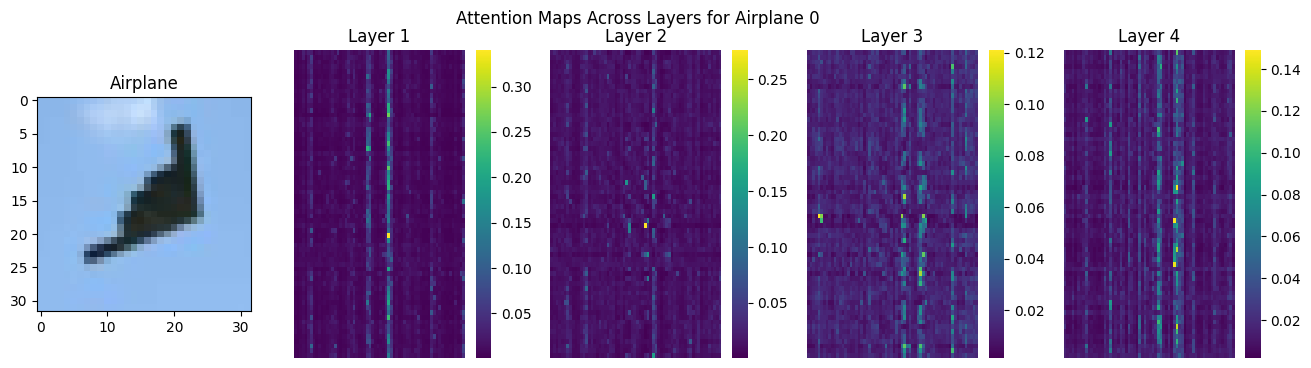

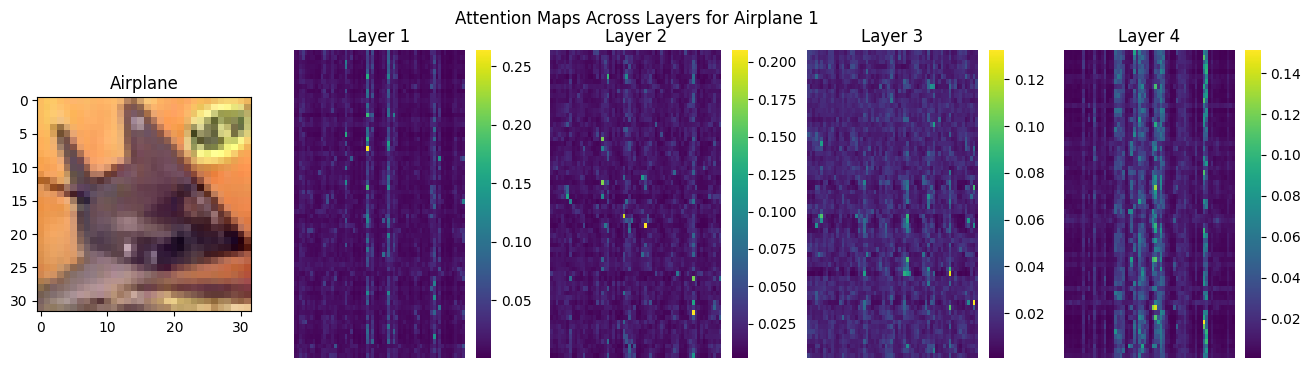

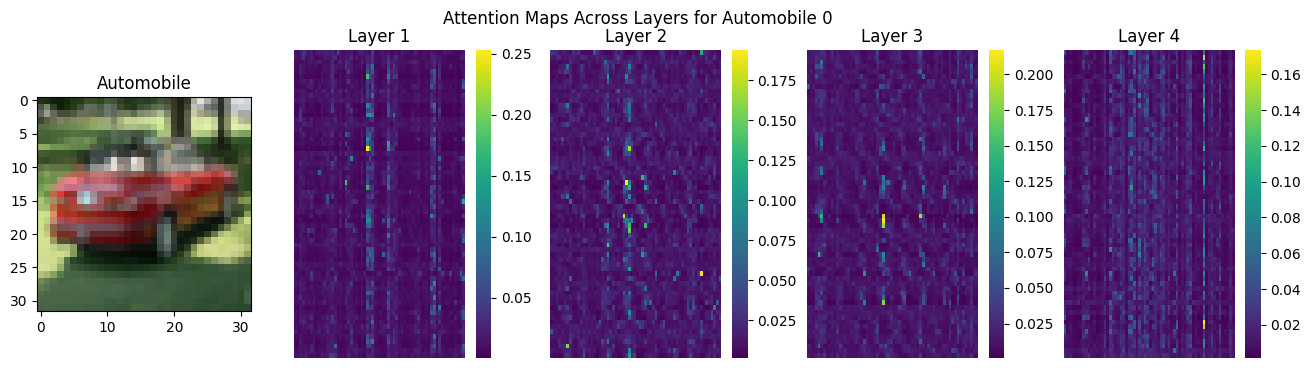

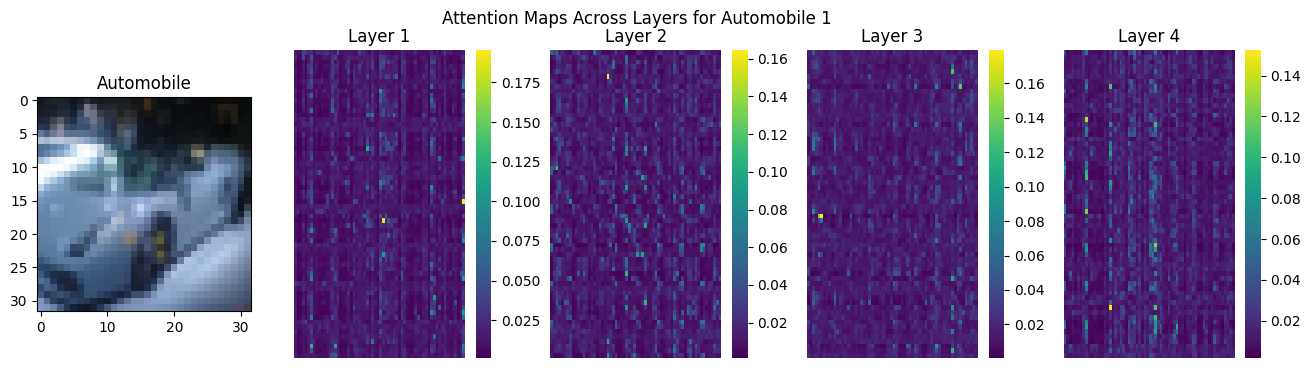

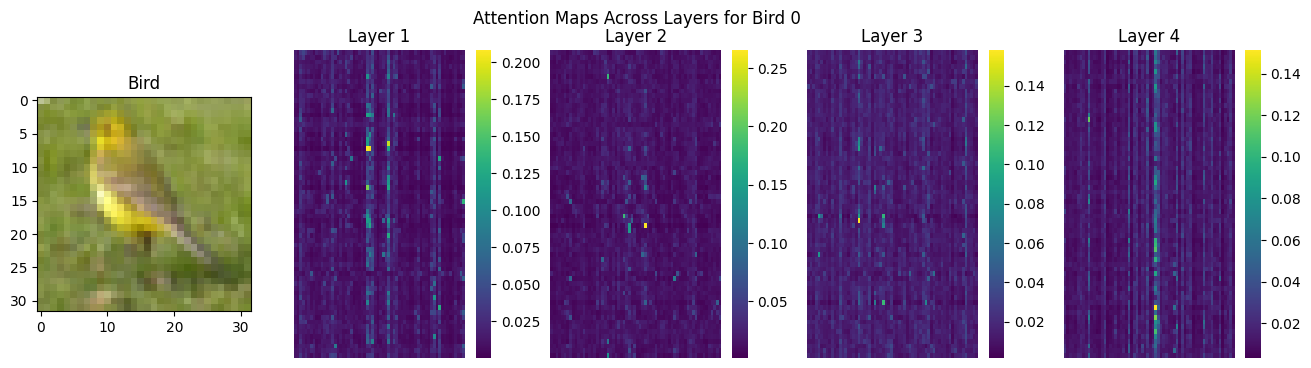

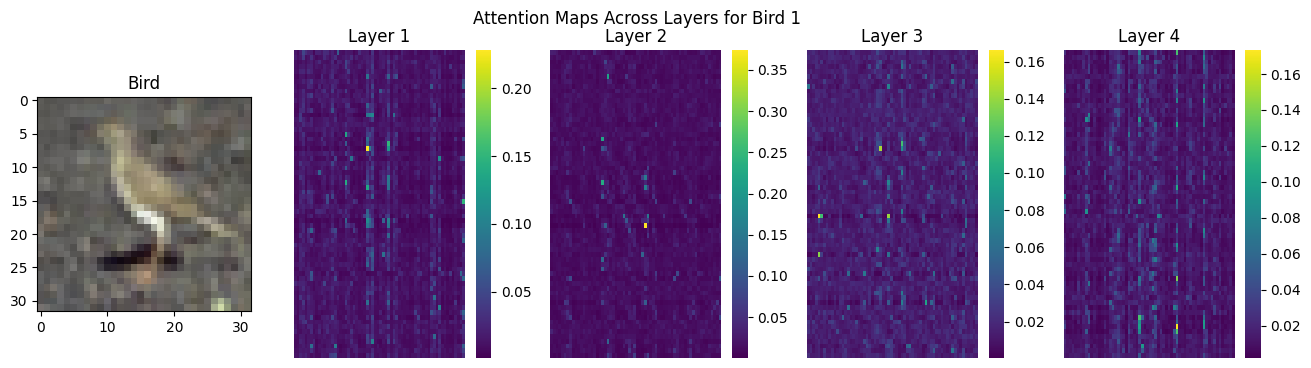

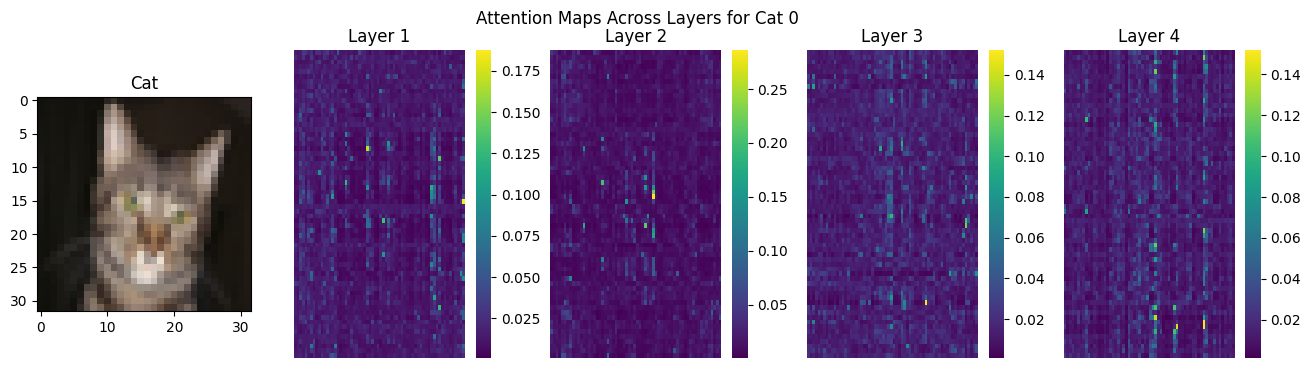

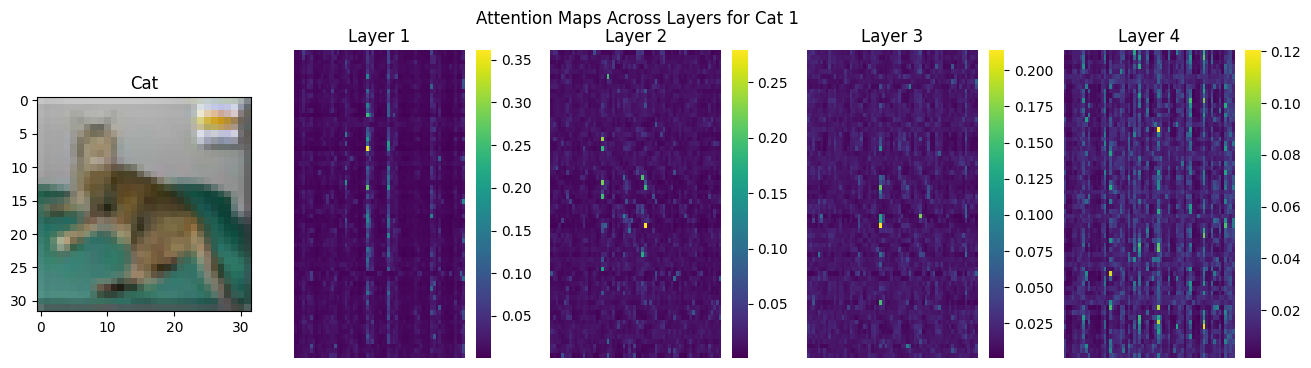

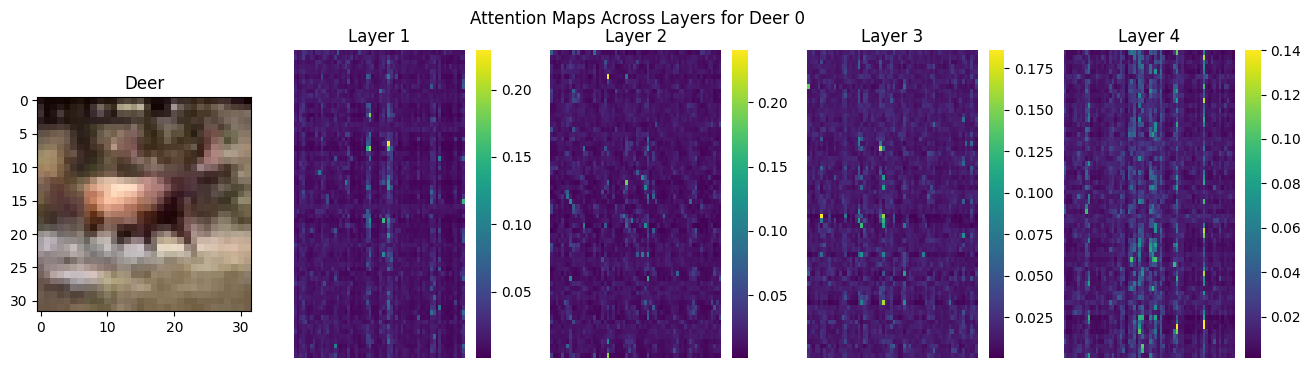

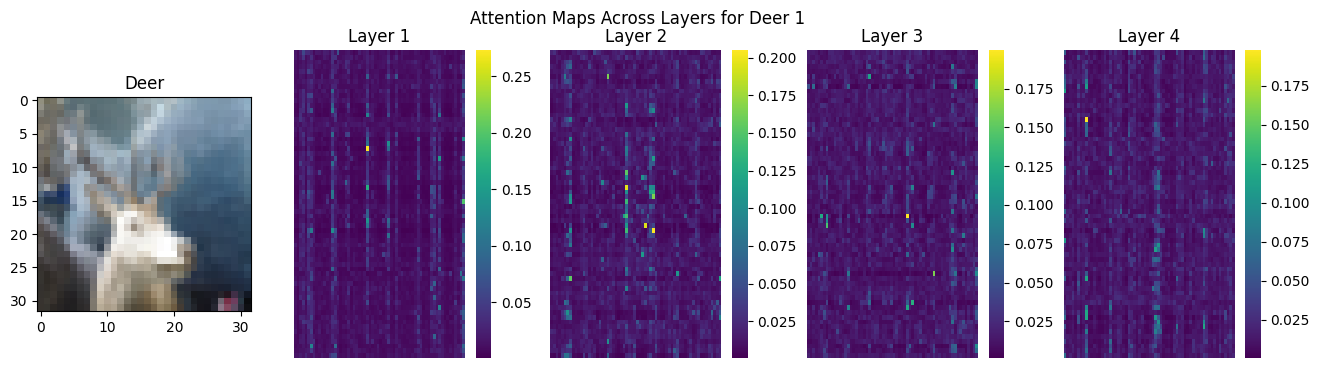

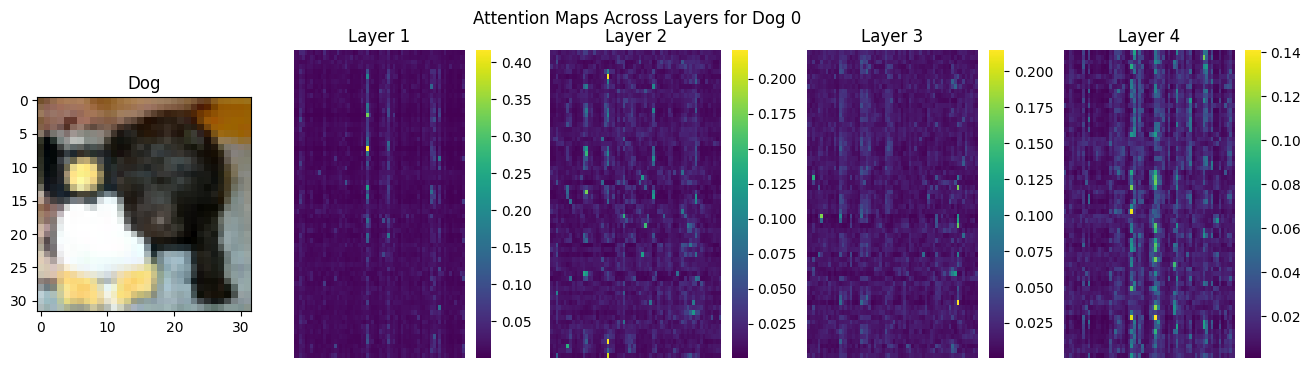

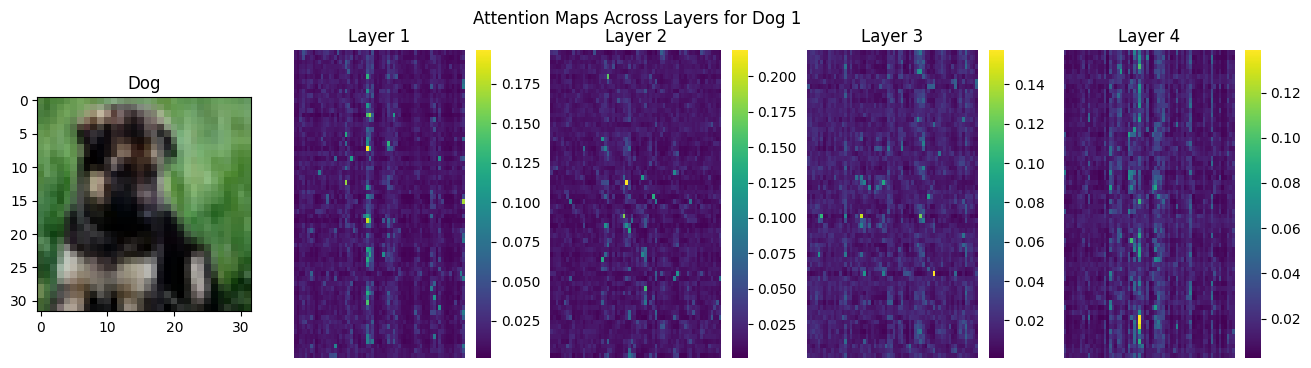

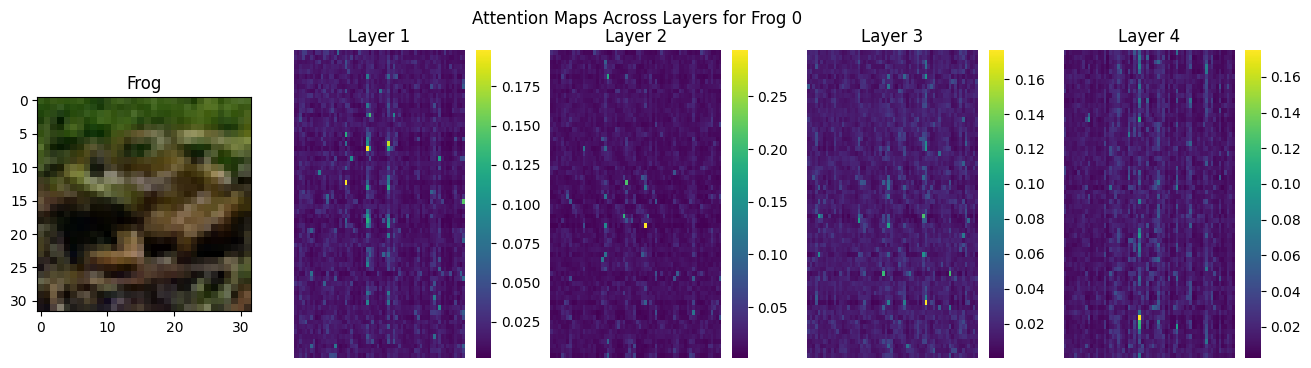

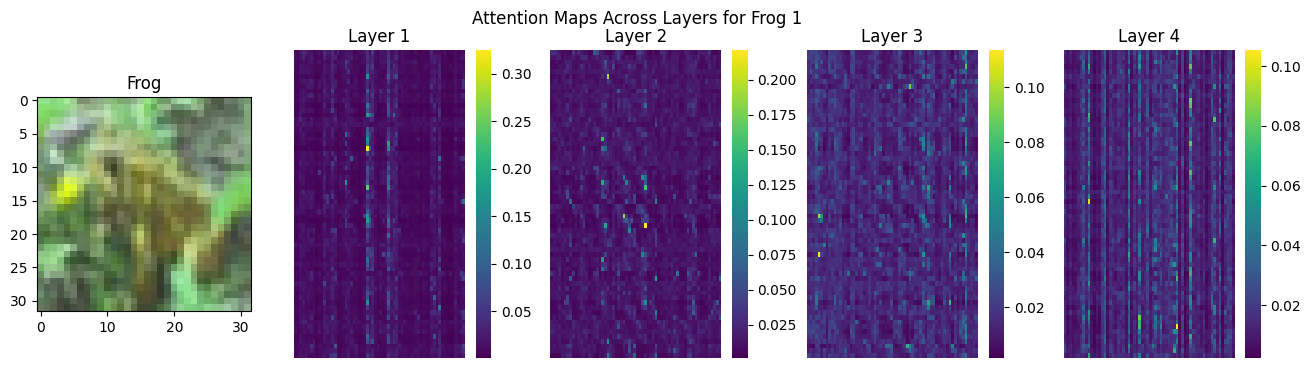

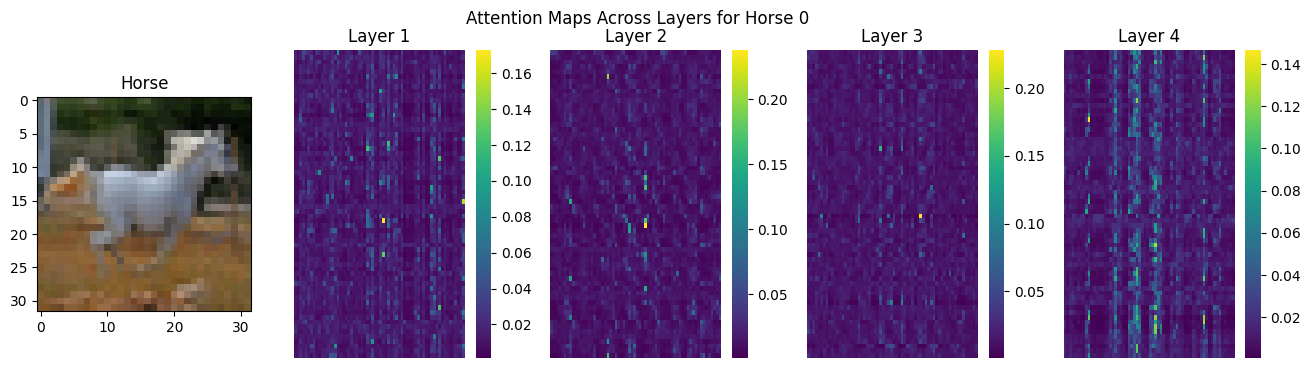

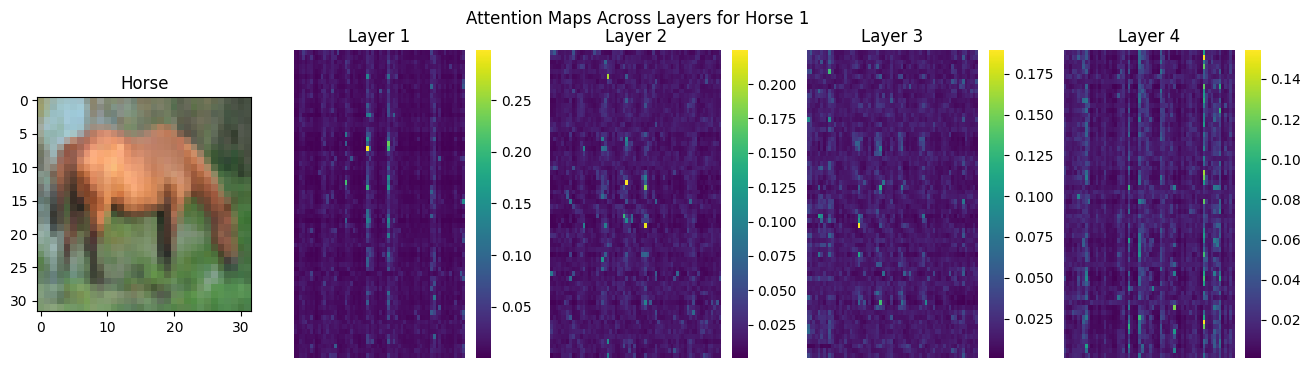

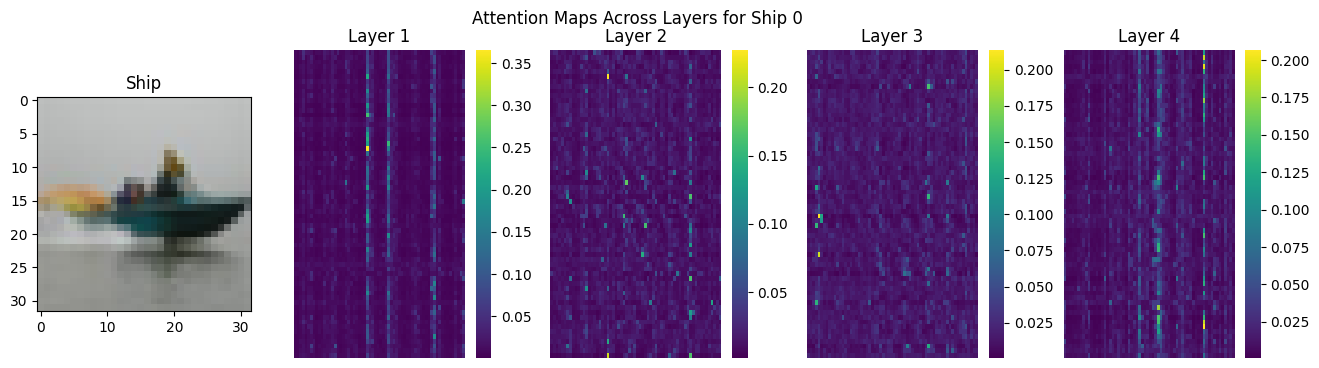

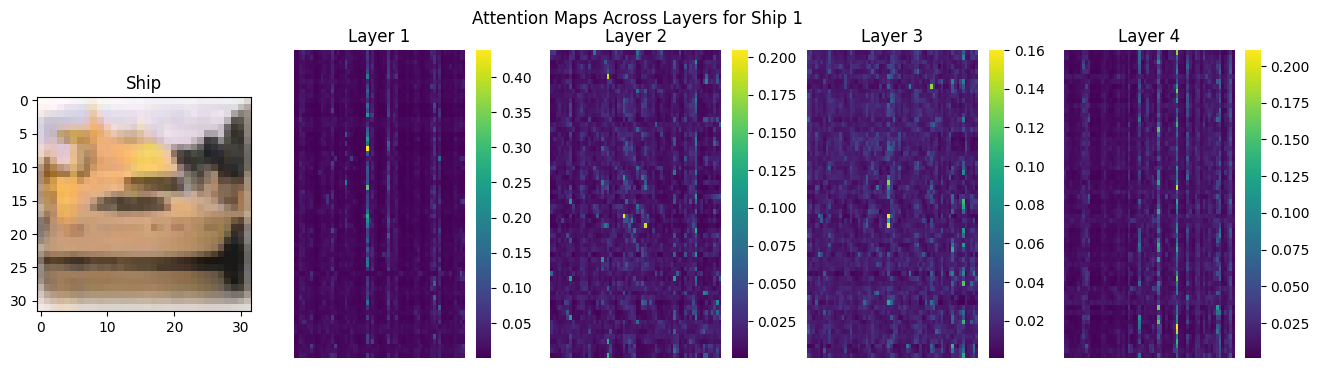

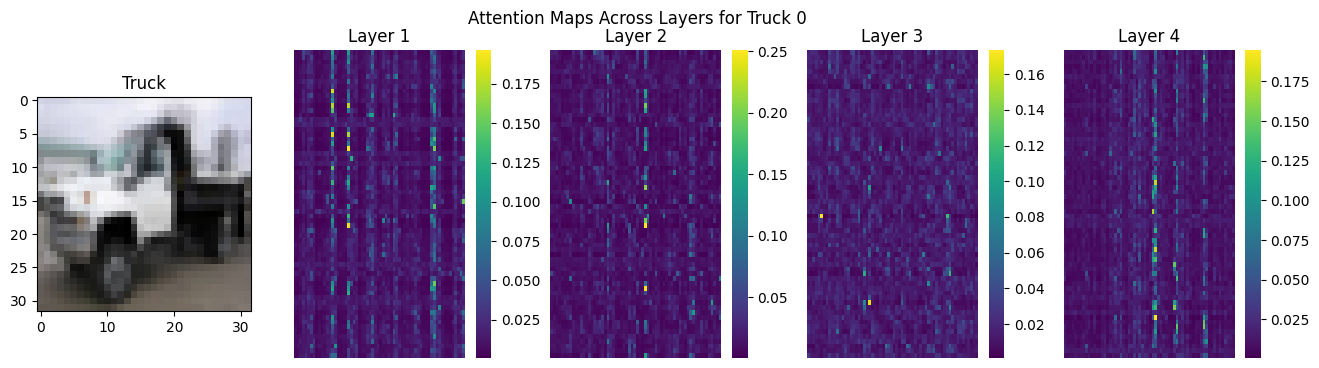

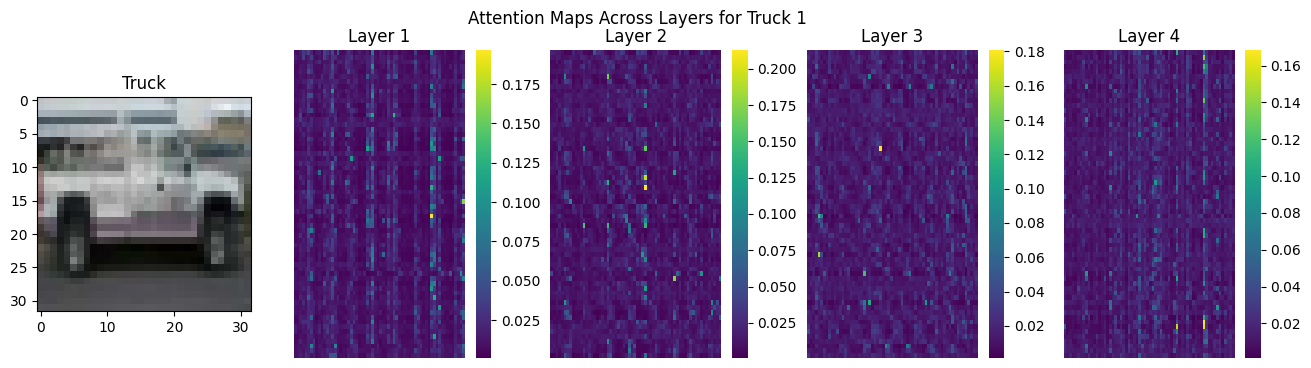

In [43]:
# Plot the attention maps for the the images per class
for cls in range(y_test_shuffled.shape[1]):
  for i in range(len(image_per_class[cls])):
    image = np.expand_dims(image_per_class[cls][i], 0)
    torch_arr = torch.tensor(image, dtype=torch.float32, device = device)
    with torch.no_grad():
        val_outputs, attention_maps = trained_model(torch_arr)
        # Convert to NumPy
        attention_maps = np.array([np.array(attention_maps[index].cpu()) for index in range(len(attention_maps))])  # (num_layers, batch, num_heads, num_patches+1, num_patches+1)
        
        # Ignore CLS token (first patch), keep only image patches
        attention_maps = attention_maps[:, :, :, 1:, 1:]  # Shape: (num_layers, batch, num_heads, num_patches, num_patches)
        
        # Aggregate attention: Average across heads, sum over layers
        mean_attention = np.mean(attention_maps, axis=2)  # Avg over heads -> (num_layers, batch, num_patches, num_patches)
        plot_attention_layers(image_per_class[cls][i], mean_attention, cls, i)

#### Rolling Attentions

In [64]:
from PIL import Image
import cv2
results = {}
for cls in range(y_test_shuffled.shape[1]):
  results[cls] = []
  for i in range(len(image_per_class[cls])):
    pil_img = image = Image.fromarray((image_per_class[cls][i]*255).astype(np.uint8))
    image = np.expand_dims(image_per_class[cls][i], 0)
    torch_arr = torch.tensor(image, dtype=torch.float32, device = device)
    with torch.no_grad():
        _, all_attentions = trained_model(torch_arr)
    
    
    # layers, batch_size, attention_heads, seq, seq
    alls = torch.stack(all_attentions)
    alls = alls.cpu()
    # layers, attention_heads, seq, seq because batch_size is 1
    alls = torch.squeeze(alls)
    # average the attention weights
    att_mat = torch.mean(alls, dim=1)
    # print(att_mat.shape)
    
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    
    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]
    
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    result = cv2.resize(mask / mask.max(), pil_img.size)
    results[cls].append(result)
     

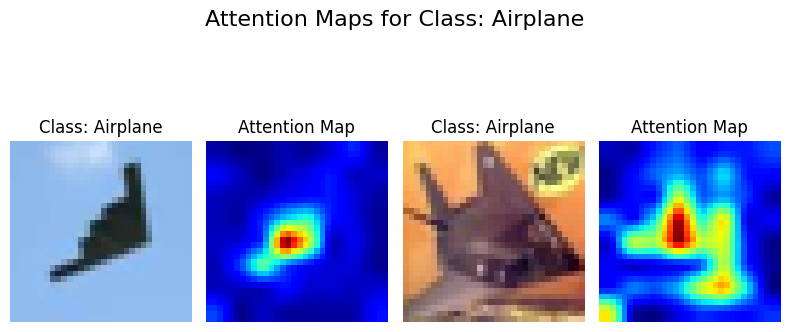

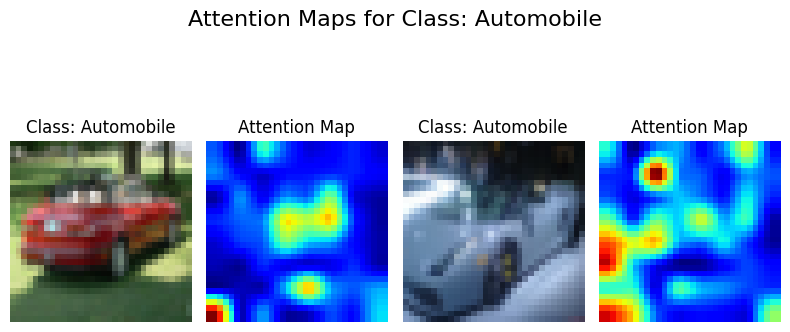

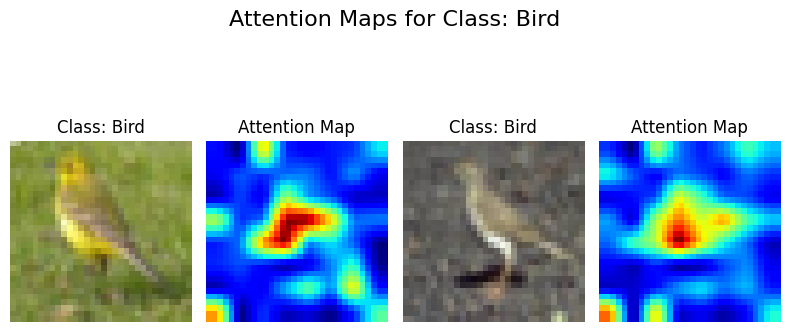

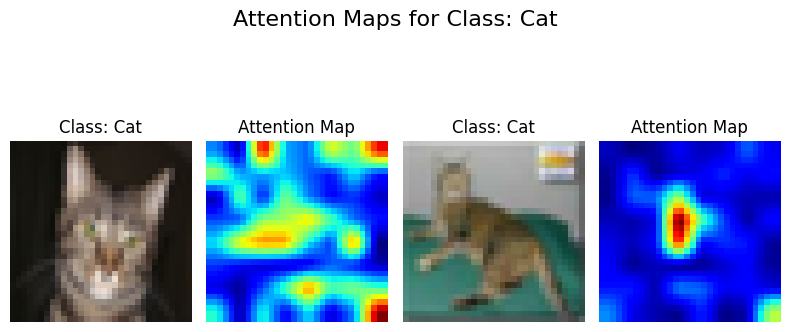

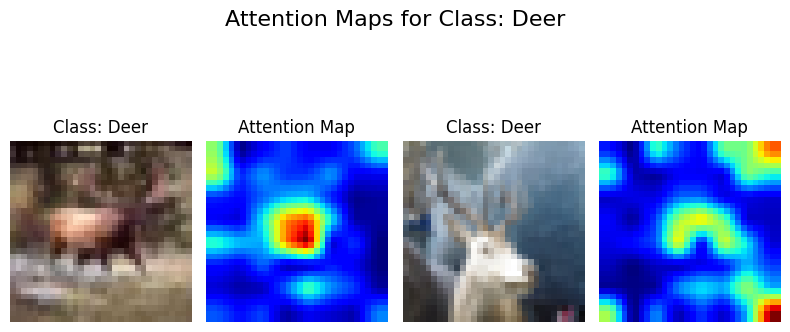

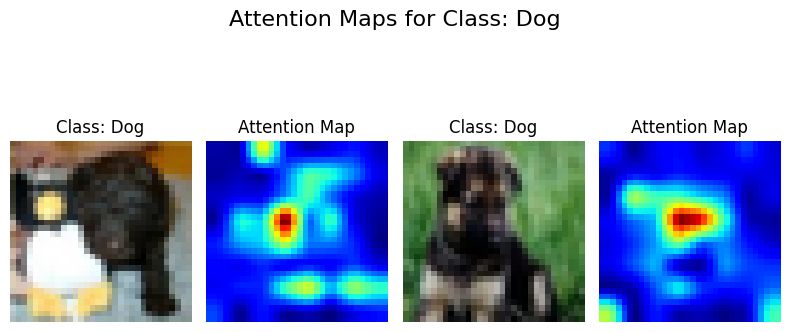

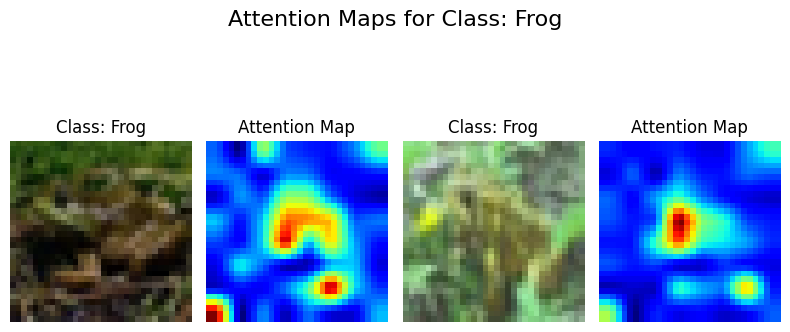

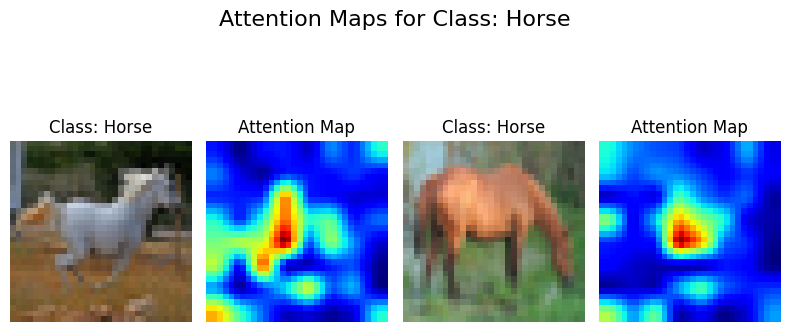

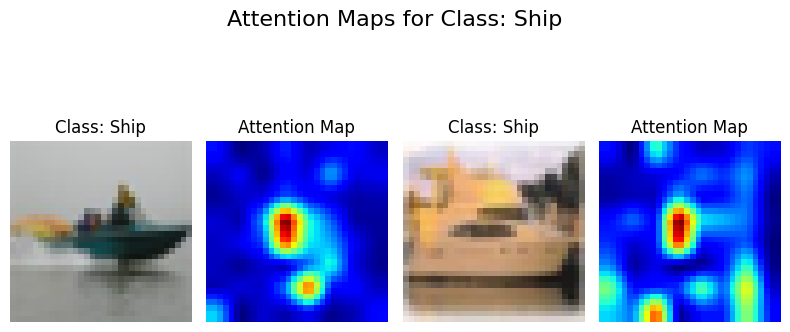

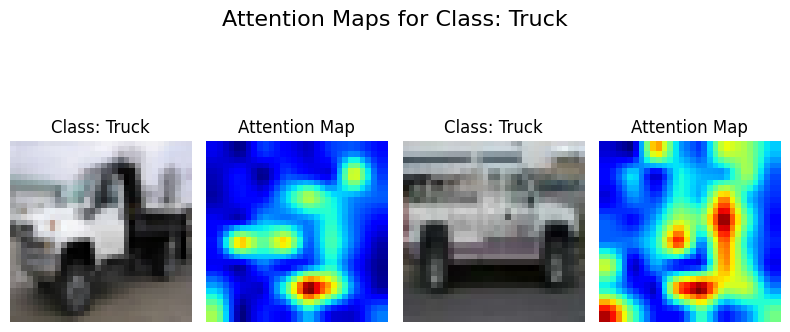

In [77]:
import matplotlib.pyplot as plt

# Loop through each class
for cls in range(y_test_shuffled.shape[1]):
    num_images = len(image_per_class[cls])  # Number of images in this class

    # Create a single row figure (each pair: [Image | Attention Map])
    fig, axes = plt.subplots(1, num_images * 2, figsize=(4 * num_images, 4))

    for i in range(num_images):
        image = image_per_class[cls][i]

        # Original Image (placed at even indices: 0, 2, 4, ...)
        axes[i * 2].imshow(image)
        axes[i * 2].set_title(f"Class: {classes.get(cls)}", fontsize=12)
        axes[i * 2].axis("off")

        # Attention Map (placed at odd indices: 1, 3, 5, ...)
        axes[i * 2 + 1].imshow(results[cls][i], cmap="jet")  # Using "jet" for better contrast
        axes[i * 2 + 1].set_title("Attention Map", fontsize=12)
        axes[i * 2 + 1].axis("off")

    # Set a title for the entire figure
    plt.suptitle(f"Attention Maps for Class: {classes.get(cls)}", fontsize=16)

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.94])

    # Show the entire figure
    plt.show()
